In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
from IPython.display import display
%matplotlib inline

In [2]:
currency_pairs = ['USDT_BTC', 'BTC_ETH', 'BTC_XMR', 'BTC_XRP', 'BTC_FCT', 'BTC_NAV', 'BTC_DASH', 'BTC_MAID', 'BTC_ZEC']
currency_pair = currency_pairs[0]

In [3]:
folder = '../data/'
files = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(folder)) for f in fn]
datafiles = sorted([f for f in files if f.endswith('.log.gz')])
print(datafiles[0])
print(datafiles[-1])
print("Number of datafiles to extract from: {}".format(len(datafiles)))

../data/2016-11-08/poloniex_full_2016-11-08T10:00:09.955811.log.gz
../data/2016-12-08/poloniex_full_2016-12-08T13:29:04.537984.log.gz
Number of datafiles to extract from: 43392


In [4]:
from manage_orderbooks import *

In [5]:
num_samples = None
range_factor = 1.5

filename = "../data/snapshots/orderbooks_{}_range{}_samples{}_snapshot{}.dict".format(
    currency_pair, range_factor, num_samples, str(datetime.now().isoformat())[:-10])
print(filename)

../data/snapshots/orderbooks_USDT_BTC_range1.5_samplesNone_snapshot2016-12-08T13:29.dict


In [6]:
query_idx = [0, 1, 60, -60, -2, -1]
extract_orderbooks_for_one_currencypair([datafiles[idx] for idx in query_idx], currency_pair='USDT_BTC',
                                        outfile=filename,
                                        range_factor=range_factor, num_samples=num_samples, float_precision=2)

  0%|          | 0/6 [00:00<?, ?it/s]

Orderbook content will be written to '../data/snapshots/orderbooks_USDT_BTC_range1.5_samplesNone_snapshot2016-12-08T13:29.dict'


/usr/lib64/python2.7/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

Successfully created file '../data/snapshots/orderbooks_USDT_BTC_range1.5_samplesNone_snapshot2016-12-08T13:29.dict'


In [7]:
orderbooks, timestamps = load_orderbook_snapshot(infile=filename)
display(timestamps)
print(len(orderbooks[0]))

100%|██████████| 6/6 [00:00<00:00, 35.44it/s]

Loaded Orderbooks: 6


[u'2016-11-08T10:00:01.739243',
 u'2016-11-08T10:01:01.720136',
 u'2016-11-08T11:01:02.175009',
 u'2016-12-08T12:30:01.887441',
 u'2016-12-08T13:28:01.569265',
 u'2016-12-08T13:29:01.536055']

1267


In [8]:
def market_order(orderbook, amount, limit=None):
    assert isinstance(orderbook, pd.DataFrame)
    assert isinstance(amount, float) or isinstance(amount, int)
    assert amount != 0
    
    cash = 0
    if amount > 0:
        # buy from market
        df = orderbook[orderbook.Type=='ask']     
        for pos in range(len(df)):
            order = df.iloc[pos]
            if amount - order.Amount >= 0:
                purchase_amount = order.Amount
            else:
                purchase_amount = amount
            
            cash -= purchase_amount * order.Price
            amount -= purchase_amount
            if amount == 0:
                break
    elif amount < 0:
        # sell to market
        df = orderbook[orderbook.Type=='bid']        
        for pos in range(len(df)):
            order = df.iloc[-pos-1]
            if amount + order.Amount <= 0:
                sell_amount = - order.Amount
            else:
                sell_amount = amount
            cash -= sell_amount * order.Price
            amount -= sell_amount
            if amount == 0:
                break
    if abs(amount) > 0:
        print("error: empty orderbook! Could not trade all shares. {} left".format(amount))
            
    return cash
    

trade_vol = 1000.
print("buying {} shares currently costs: {}".format(trade_vol, (market_order(orderbooks[0], trade_vol))))
print("")
print("selling {} shares currently returns: {}".format(trade_vol, market_order(orderbooks[0], -trade_vol)))

error: empty orderbook! Could not trade all shares. 549.07892622 left
buying 1000.0 shares currently costs: -339137.870858

error: empty orderbook! Could not trade all shares. -325.4697607 left
selling 1000.0 shares currently returns: 428816.47338


6
(0, u'2016-11-08T10:00:01.739243')


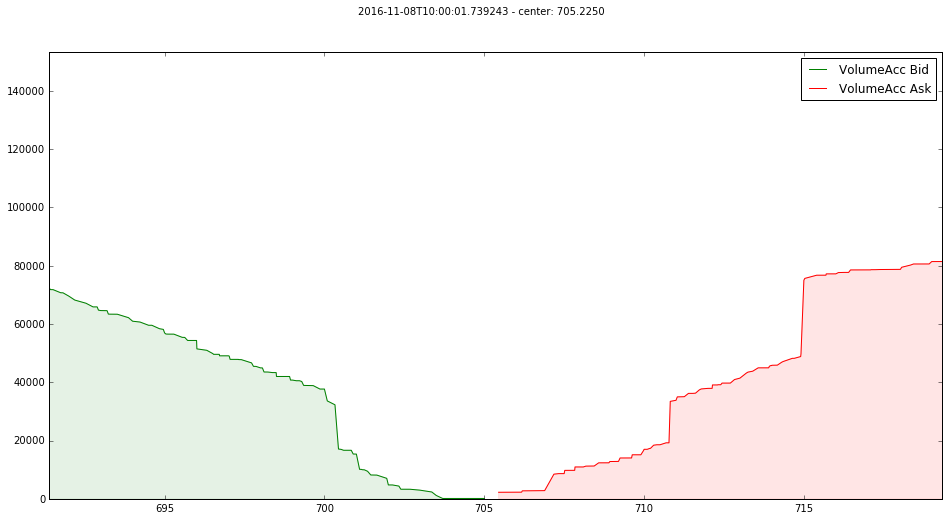

(1, u'2016-11-08T10:01:01.720136')


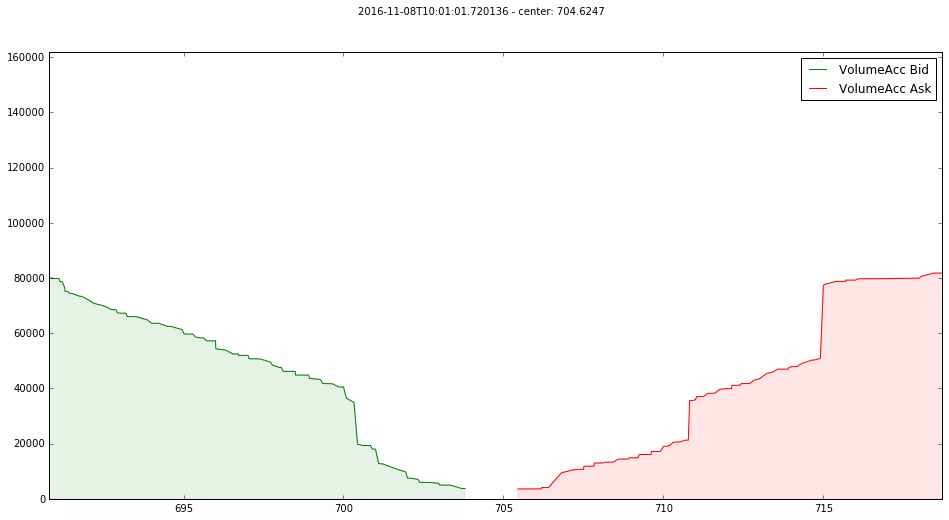

(2, u'2016-11-08T11:01:02.175009')


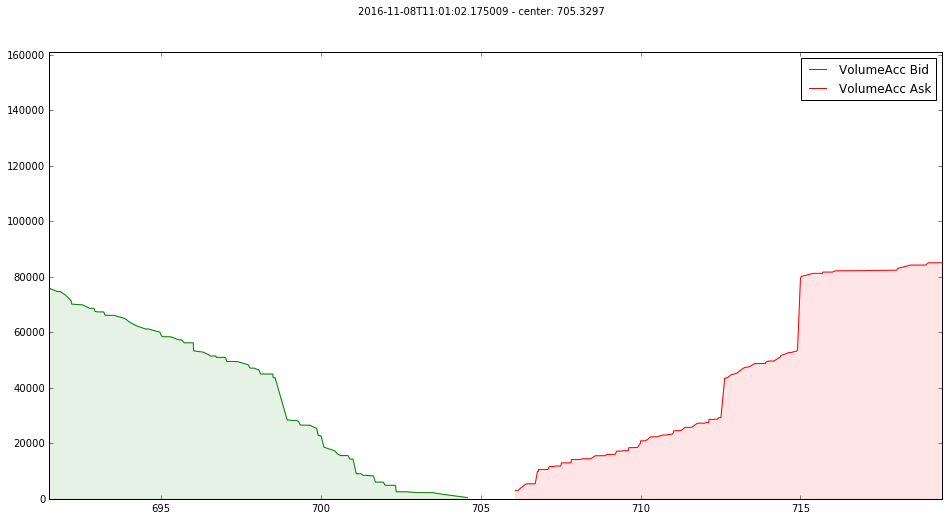

(3, u'2016-12-08T12:30:01.887441')


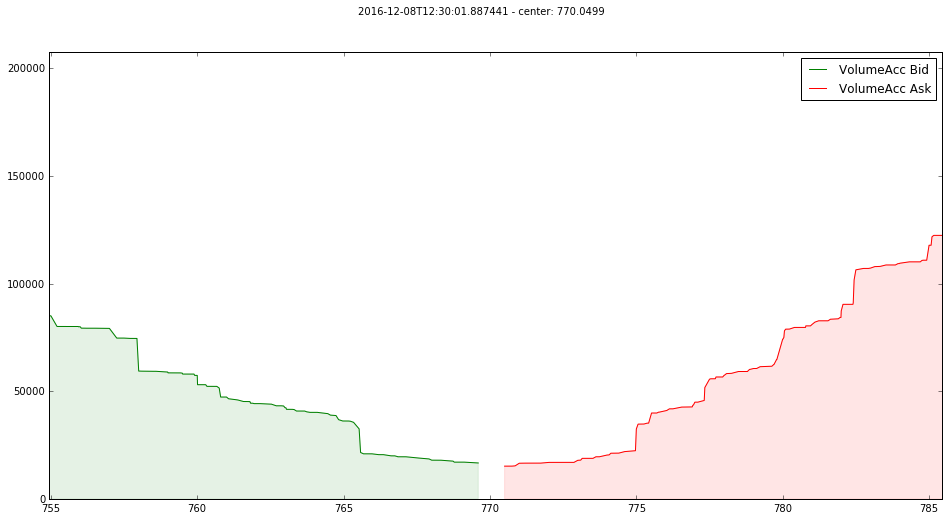

(4, u'2016-12-08T13:28:01.569265')


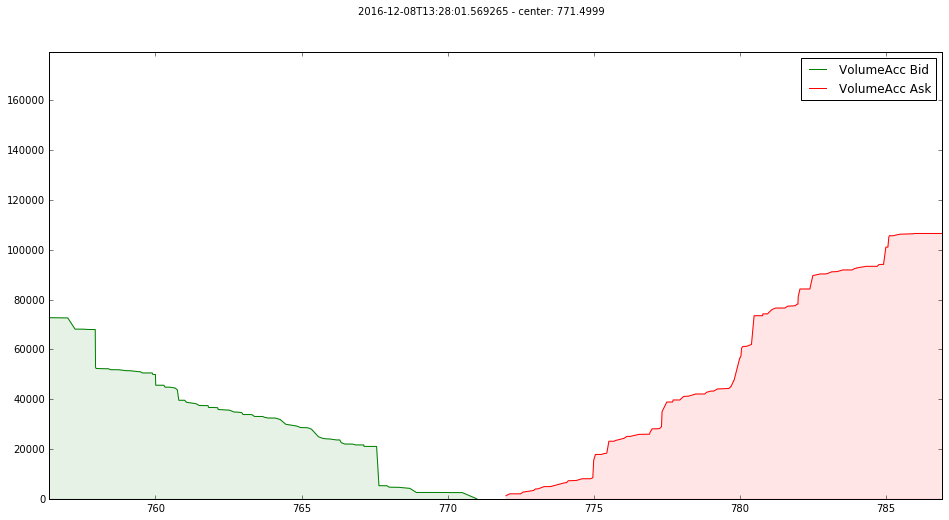

(5, u'2016-12-08T13:29:01.536055')


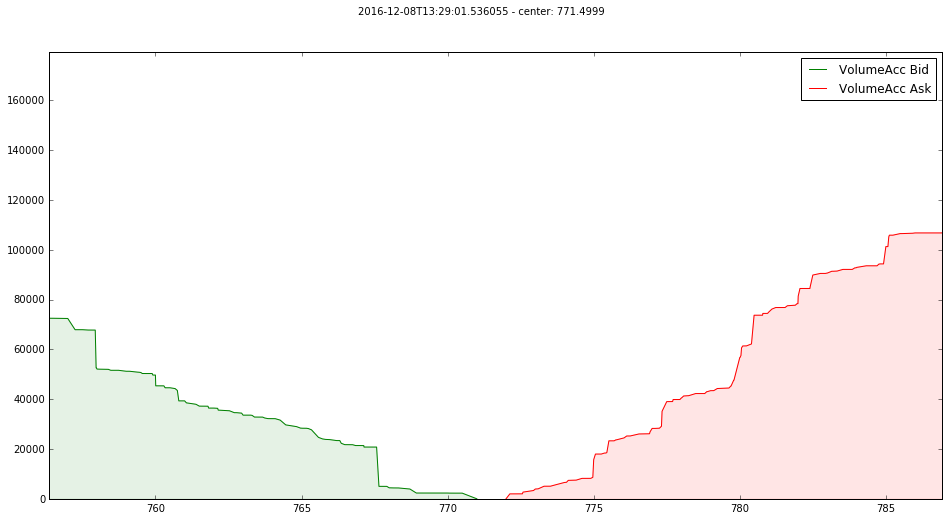

In [9]:

range_factor = 1.02
# plot_orderbook(data[0], normalized=True, range_factor=range_factor)
print(len(orderbooks))
for idx in range(len(query_idx)):
    print(idx, timestamps[idx])
    plot_orderbook(orderbooks[idx], title=timestamps[idx], normalized=False, range_factor=range_factor)